In [275]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, plot_confusion_matrix

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


import re
import nltk
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer


In [240]:
# import file
df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')

In [241]:
# Preview file 
df.head(10)

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
7,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
8,Beautifully smart and simple idea RT @madebyma...,iPad or iPhone App,Positive emotion
9,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion


In [242]:
# Overview file
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       3291 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9093 non-null object
dtypes: object(3)
memory usage: 213.2+ KB


In [243]:
# Value counts exploration
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [244]:
# Fill nulls
df['emotion_in_tweet_is_directed_at'].fillna('None', inplace=True)

In [245]:
# Recheck
df['emotion_in_tweet_is_directed_at'].value_counts()

None                               5802
iPad                                946
Apple                               661
iPad or iPhone App                  470
Google                              430
iPhone                              297
Other Google product or service     293
Android App                          81
Android                              78
Other Apple product or service       35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [246]:
# Value counts exploration
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [247]:
# Filter down emotions to Neutral
df['is_there_an_emotion_directed_at_a_brand_or_product'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"No emotion toward brand or product" : "Neutral",
                                                                                                                         "Positive emotion": "Positive",
                                                                                                                         "Negative emotion": "Negative",
                                                                                                                         "I can't tell": "Neutral"})

In [248]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

Neutral     5545
Positive    2978
Negative     570
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [249]:
df['target'] = df['is_there_an_emotion_directed_at_a_brand_or_product'].map({"Positive": 1,
                                                                             "Neutral": 0,
                                                                             "Negative": 0})

In [250]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,target
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive,1


In [251]:
df.isnull().sum()

tweet_text                                            1
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
target                                                0
dtype: int64

In [252]:
df[df['tweet_text'].isnull()]

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,target
6,NaN,None,Neutral,0


In [253]:
# drop row 6
df.drop(labels=6, axis=0, inplace=True)

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 4 columns):
tweet_text                                            9092 non-null object
emotion_in_tweet_is_directed_at                       9092 non-null object
is_there_an_emotion_directed_at_a_brand_or_product    9092 non-null object
target                                                9092 non-null int64
dtypes: int64(1), object(3)
memory usage: 355.2+ KB


In [255]:
# Grabbing our inputs and target
X = df['tweet_text']
y = df['target']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [256]:
stopwords_list = stopwords.words('english') + list(string.punctuation)

In [257]:
# Intstantiating our vectorizer
count_vectorizer = CountVectorizer()

# Training on the train set, then transforming the train set
X_train_count = count_vectorizer.fit_transform(X_train)
# Transforming the test set
X_test_count = count_vectorizer.transform(X_test)

In [258]:
X_train_count

<6819x8607 sparse matrix of type '<class 'numpy.int64'>'
	with 111525 stored elements in Compressed Sparse Row format>

In [259]:
# Instantiating a classifier to use on this text - Multinomial Naive Bayes
nb_classifier = MultinomialNB()

# Fitting the classifier
nb_classifier.fit(X_train_count, y_train)

# Getting our predictions for the train and test sets
train_preds = nb_classifier.predict(X_train_count)
test_preds = nb_classifier.predict(X_test_count)

0.7245930488341399


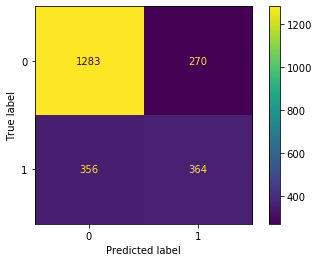

In [260]:
# Let's see how we did!
print(accuracy_score(y_test, test_preds))

plot_confusion_matrix(nb_classifier, X_test_count, y_test, values_format = '')

In [261]:
def classify_vectorized_text(vectorizer, classifier, Xtrain, Xtest, ytrain, ytest):
    '''
    Fit and transform text data using the provided vectorizer, then fit and 
    predict with the provided classifier, in order to see the resulting
    accuracy score and confusion matrix
    For the Xtrain, Xtest, ytrain, ytest, expect the output of an
    sklearn train/test split
    -
    Inputs:
    vectorizer: an instantiated sklearn vectorizer
    classifier: an instantiated sklearn classifier
    X_train: training input data
    X_test: testing input data
    y_train: training true result
    y_test: testing true result
    -
    Outputs: 
    train_preds: predicted results for the train set
    test_preds: predicted results for the test set
    '''

    Xtrain_transformed = vectorizer.fit_transform(Xtrain)
    Xtest_transformed = vectorizer.transform(Xtest)

    classifier.fit(Xtrain_transformed, ytrain)

    train_preds = classifier.predict(Xtrain_transformed)
    test_preds = classifier.predict(Xtest_transformed)

    print(accuracy_score(ytest, test_preds))
    plot_confusion_matrix(classifier, Xtest_transformed, ytest,
                          values_format=".4g")  # to make numbers readable
    plt.show()

    return(train_preds, test_preds)

In [270]:
# Instantiating a count vectorizer that removes stop words
count_stop = CountVectorizer(stop_words=stopwords_list)

count_stop_train = count_stop.fit_transform(X_train)
count_stop_test = count_stop.transform(X_test)

0.7219533655961284


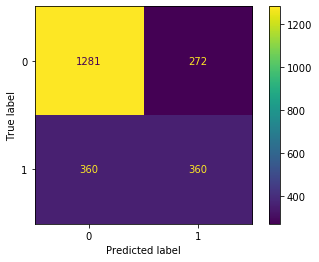

(array([1, 0, 0, ..., 1, 0, 0]), array([1, 0, 0, ..., 0, 0, 1]))

In [271]:
# Trying the same classifier, but now with stopwords removed
nb_stop = MultinomialNB()

classify_vectorized_text(count_stop, nb_stop, X_train, X_test, y_train, y_test)
# Did worse, model may be learning the wrong things

## TF-IDF

In [264]:
# Instantiating the TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words=stopwords_list, 
                        max_df = .95, # removes words that appear in more than 95% of docs
                        min_df = 2, # removes words that appear 2 or fewer times
                        use_idf=True)

# Training on the train set, then transforming the train set
tfidf_train = tfidf.fit_transform(X_train)
# Transforming the test set
tfidf_test = tfidf.transform(X_test)

In [265]:
# Creating a df of tf-idf values, where each column is a word in the vocabulary
tfidf_test_df = pd.DataFrame(tfidf_test.toarray(), columns=tfidf.get_feature_names())

In [266]:
tfidf_test_df.head()

,00,000,00am,02,03,10,100,100s,101,106,...,ûïcheck,ûïcoming,ûïline,ûïmore,ûïthe,ûïwin,ûò,ûòand,ûó,ûóthe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [267]:
# Grabbing that row once it's been vectorized
test_doc = tfidf_test_df.iloc[22]

print(test_doc.loc[test_doc > 0].sort_values(ascending=False)) # Showing values > 0
# swarm is most unique word in this tweet, more informative than other words

swarms     0.675938
crowd      0.518272
via        0.331842
launch     0.297993
ipad       0.190721
link       0.146781
mention    0.132903
Name: 22, dtype: float64


0.7237131544214694


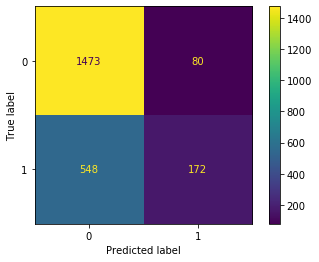

(array([0, 0, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [274]:
# Now, back to classifying: 
# Using our function to compare the results...
nb_tfidf = MultinomialNB()

classify_vectorized_text(tfidf, nb_tfidf, X_train, X_test, y_train, y_test)

0.7470303563572371


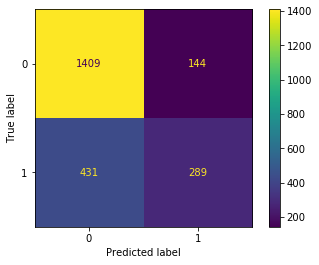

(array([1, 0, 0, ..., 1, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [276]:
# We can also use our function to try different classifiers
rfc = RandomForestClassifier(n_estimators=100)

classify_vectorized_text(tfidf, rfc, X_train, X_test, y_train, y_test)